In [1]:
import os
import cv2
import numpy as np
import keras
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

import skimage.io as io
from skimage import measure
from skimage import morphology
import matplotlib.pyplot as plt
import matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

import segmentation_models_pytorch as smp

import albumentations as albu

### Dataloader

In [2]:
# custom sort function
import re

def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)


class Dataset(BaseDataset):
    
    CLASSES = ['background', 'void']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        sort_nicely(self.ids)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) 

### Augmentations

In [3]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        albu.OneOf(
            [
                albu.HorizontalFlip(p=1),
                albu.VerticalFlip(p=1),
                albu.RandomRotate90(p=1)
            ],
            p=0.5,
        ),

        albu.ShiftScaleRotate(scale_limit=0.25, rotate_limit=0, shift_limit=0.1, p=0.5, border_mode=0),
        
        albu.RandomBrightnessContrast(brightness_limit=0.15, contrast_limit=0.15, p=0.5),  

        albu.PadIfNeeded(min_height=1024, min_width=1024, always_apply=True, border_mode=0),
#         albu.RandomCrop(height=1024, width=1024, always_apply=True),

        albu.OneOf(
            [
                albu.Sharpen(alpha=(0.0, 0.2), p=1),
                albu.CLAHE(p=1),
                albu.GaussianBlur(p=1),
                albu.GaussNoise(var_limit=(0.0, 20.0), p=1),
            ],
            p=0.5,
        ),
        
        albu.Lambda(mask=round_clip_0_1)
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
    albu.PadIfNeeded(1024, 1024)
    ]
    
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

### Segmentation model 

In [6]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = None   # None (random initialization); 'imagenet' (pre-trained on ImageNet)
BATCH_SIZE = 2
NUM_WORKERS = 0
CLASSES = ['void']
ACTIVATION = 'sigmoid' 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
#     encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER)

# preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# loss = smp.utils.losses.DiceLoss()

# metrics = [
#     smp.utils.metrics.IoU(threshold=0.5),
#     smp.utils.metrics.Fscore(threshold=0.5),
# ]

# optimizer = torch.optim.Adam([ 
#     dict(params=model.parameters(), lr=0.0001),
# ])

# # create epoch runners 
# train_epoch = smp.utils.train.TrainEpoch(
#     model=model, 
#     loss=loss, 
#     metrics=metrics, 
#     optimizer=optimizer,
#     device=DEVICE,
#     verbose=True,
# )

# valid_epoch = smp.utils.train.ValidEpoch(
#     model=model, 
#     loss=loss, 
#     metrics=metrics, 
#     device=DEVICE,
#     verbose=True,
# )

## Load model

In [19]:
# load best saved checkpoint
if torch.cuda.is_available():
    best_model = torch.load('./voids_segmentation_091321.pth')
else:
    best_model = torch.load('./voids_segmentation_091321.pth', map_location=torch.device('cpu'))

## Apply model to test images

In [20]:
# Directory for test images
DATA_DIR = './'

x_test_dir = os.path.join(DATA_DIR, 'test_images')
y_test_dir = os.path.join(DATA_DIR, 'test_images')

# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

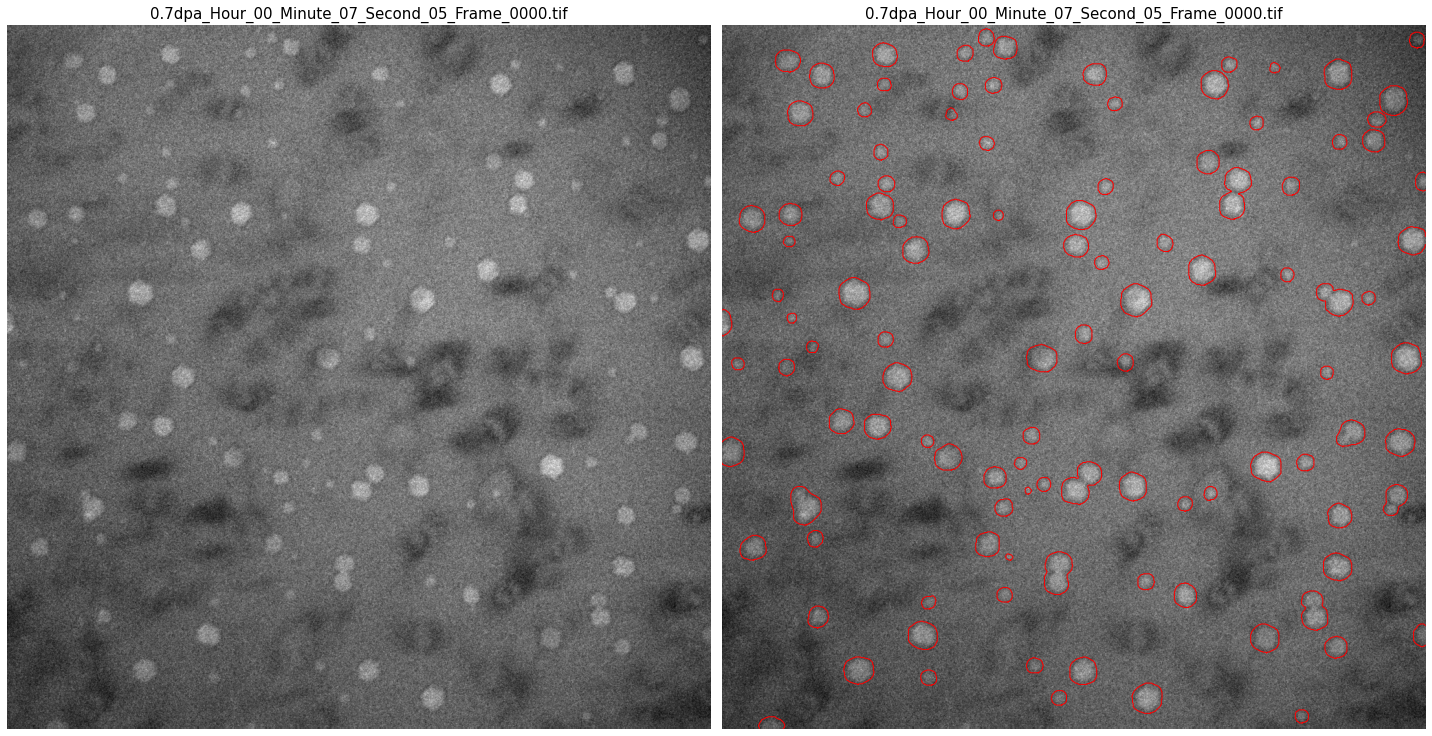

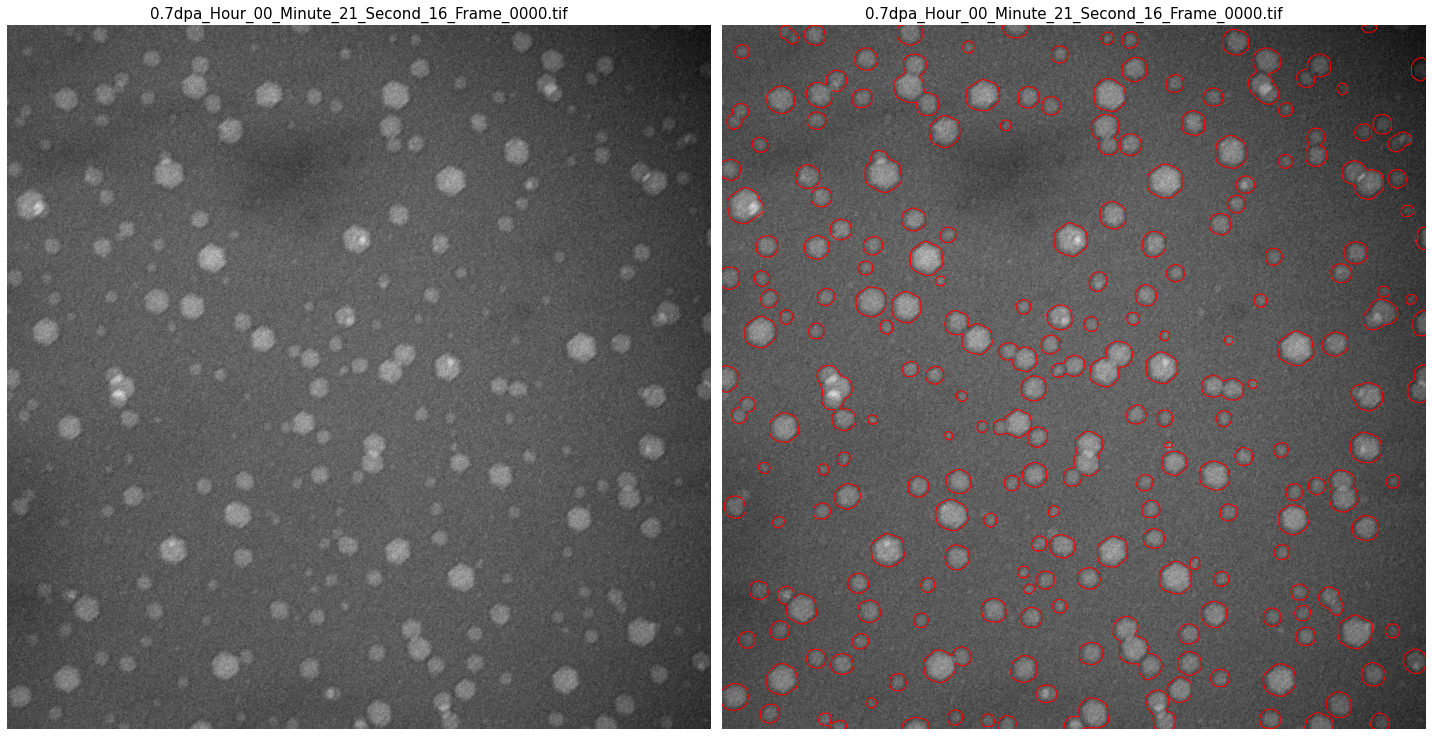

In [21]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

ids_test = os.listdir(x_test_dir)
sort_nicely(ids_test)

for i in range(len(test_dataset)):
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, _ = test_dataset[i]
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())

    id = ids_test[i]
    
    # plot mask as overlay
    img = image_vis
    mask = pr_mask
    mask = mask==1
    # mask = binary_closing(mask)
    mask = morphology.remove_small_objects(mask, 50)
    mask = morphology.remove_small_holes(mask, 50)
#     mask = morphology.binary_erosion(mask, square(1))

    contours = measure.find_contours(mask, 0)

    # Display the image and plot all contours found
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    ax[0].imshow(img, cmap=plt.cm.gray)
    ax[0].set_title(id, fontsize=15)
    ax[0].axis('off')
    ax[0].axes.xaxis.set_visible(False)
    ax[0].axes.yaxis.set_visible(False)
    
    ax[1].imshow(img, cmap=plt.cm.gray)
    ax[1].set_title(id, fontsize=15)

    for contour in contours:
        ax[1].plot(contour[:, 1], contour[:, 0], linewidth=1, alpha=1, color='red')

    ax[1].axis('off')
    ax[1].axes.xaxis.set_visible(False)
    ax[1].axes.yaxis.set_visible(False)
    plt.tight_layout()
    
    plt.show()